# SiT: Exploring Flow and Diffusion-based Generative Models with Scalable Interpolant Transformers

This notebook samples from pre-trained SiT models. SiTs are class-conSiTional latent interpolant models trained on ImageNet, unifying Flow and Diffusion Methods. 

[Paper]() | [GitHub](github.com/willisma/SiT)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the SiT GitHub repo and setup PyTorch. You only have to run this once.

In [1]:
# !git clone https://github.com/willisma/SiT.git
# import SiT, os
import os
# os.chdir('SiT')
# os.environ['PYTHONPATH'] = '/env/python:/content/SiT'
os.environ['PYTHONPATH'] = '/env/python'
!pip install diffusers timm torchdiffeq --upgrade
# SiT imports:
import torch
from torchvision.utils import save_image
from transport import create_transport, Sampler
from diffusers.models import AutoencoderKL
from download import find_model
from models import SiT_S_8
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

/home/jimmy/miniconda3/envs/SiT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download SiT-XL/2 Models

In [2]:
image_size = "256"
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = SiT_S_8(input_size=latent_size, num_classes=1).to(device)
# state_dict = find_model(f"SiT-XL-2-{image_size}x{image_size}.pt")
state_dict = find_model("results/000-SiT-S-8-Linear-velocity-None/checkpoints/0024000.pt")
for name, param in state_dict.items():
    print(name, param.shape)        # Print parameter name and shape
    print(param)                    # Print the actual tensor (can be large!)
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

/home/jimmy/codes/SiT/download.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_name, map_location=lambda storage, loc: storage)


pos_embed torch.Size([1, 16, 384])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.8415, 0.7886, 0.7348,  ..., 1.0000, 1.0000, 1.0000],
         [0.9093, 0.9698, 0.9967,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8415, 0.7886, 0.7348,  ..., 1.0000, 1.0000, 1.0000],
         [0.9093, 0.9698, 0.9967,  ..., 1.0000, 1.0000, 1.0000],
         [0.1411, 0.4041, 0.6174,  ..., 1.0000, 1.0000, 1.0000]]])
x_embedder.proj.weight torch.Size([384, 4, 8, 8])
tensor([[[[-0.0184,  0.0423,  0.0796,  ...,  0.0147, -0.0797,  0.0447],
          [ 0.0828, -0.0781, -0.0213,  ...,  0.0273,  0.0426, -0.0500],
          [-0.0380,  0.0547,  0.0610,  ..., -0.0556, -0.0684, -0.0020],
          ...,
          [ 0.0647, -0.0183,  0.0467,  ..., -0.0321,  0.0003, -0.0119],
          [-0.0056,  0.0261, -0.0408,  ...,  0.0035,  0.0564,  0.0371],
          [-0.0600,  0.0597,  0.0101,  ..., -0.0417,  0.0662, -0.0730]],

         [[-0.0093, -0.0712,  0.0328,  ..., -0.0157,  0.0857

# 2. Sample from Pre-trained SiT Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

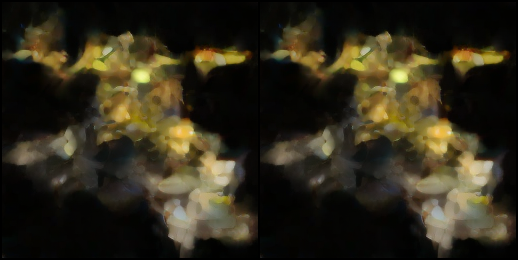

In [3]:
# Set user inputs:
seed = 69 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 1 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = [0] #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}
sampler_type = "ODE" #@param ["ODE", "SDE"]


# Create diffusion object:
transport = create_transport()
sampler = Sampler(transport)

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler" #@param ["Euler", "Heun"]
    diffusion_form = "linear" #@param ["constant", "SBDM", "sigma", "linear", "decreasing", "increasing-decreasing"]
    diffusion_norm = 1 #@param {type:"slider", min:0, max:10.0, step:0.1}
    last_step = "Mean" #@param ["Mean", "Tweedie", "Euler"]
    last_step_size = 0.4 #@param {type:"slider", min:0, max:1.0, step:0.01}
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form, 
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size, 
        num_steps=num_sampling_steps,
    ) 
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5" #@param ["dopri5", "euler", "rk4"]
    atol = 1e-6
    rtol = 1e-3
    sample_fn = sampler.sample_ode(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    ) 
samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

# # Delete this tensor to free up VRAM
# del samples

# # Empty the CUDA cache
# torch.cuda.empty_cache()
